In [1]:
%matplotlib inline
from IPython.core.display import HTML, display
import plotly
import plotly.graph_objects as go
import noise
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import axes3d
# %matplotlib qt # for this run pip install pyqt5

## 3D visualization of gradient descent

This notebook is a reproduction of the tutorials:
- https://jackmckew.dev/3d-terrain-in-python.html#3d-terrain-in-python
- https://jackmckew.dev/3d-gradient-descent-in-python.html 

In [2]:
help(noise.pnoise2)
help(noise.pnoise3)

Help on built-in function noise2 in module noise._perlin:

noise2(...)
    noise2(x, y, octaves=1, persistence=0.5, lacunarity=2.0, repeatx=1024, repeaty=1024, base=0.0)
    
    2 dimensional perlin improved noise function (see noise3 for more info)

Help on built-in function noise3 in module noise._perlin:

noise3(...)
    noise3(x, y, z, octaves=1, persistence=0.5, lacunarity=2.0repeatx=1024, repeaty=1024, repeatz=1024, base=0.0)
    
    return perlin "improved" noise value for specified coordinate
    
    octaves -- specifies the number of passes for generating fBm noise,
    defaults to 1 (simple noise).
    
    persistence -- specifies the amplitude of each successive octave relative
    to the one below it. Defaults to 0.5 (each higher octave's amplitude
    is halved). Note the amplitude of the first pass is always 1.0.
    
    lacunarity -- specifies the frequency of each successive octave relative
    to the one below it, similar to persistence. Defaults to 2.0.
    
    

In [3]:
# parameters for noise()
shape = (50,50)
scale = 100.0
octaves = 6
persistence = 0.5
lacunarity = 2.0

In [4]:
world = np.zeros(shape)
for i in range(shape[0]):
    for j in range(shape[1]):
        world[i][j] = noise.pnoise2(i/scale, 
                                    j/scale, 
                                    octaves=octaves, 
                                    persistence=persistence, 
                                    lacunarity=lacunarity, 
                                    repeatx=1024, 
                                    repeaty=1024, 
                                    base=42)

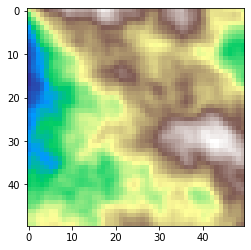

In [5]:
matplotlib.pyplot.imshow(world,cmap='terrain')

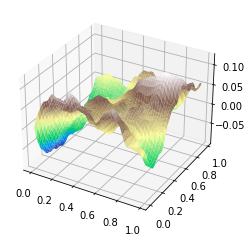

In [6]:
lin_x = np.linspace(0,1,shape[0],endpoint=False)
lin_y = np.linspace(0,1,shape[1],endpoint=False)
x,y = np.meshgrid(lin_x,lin_y)
fig = matplotlib.pyplot.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(x,y,world,cmap='terrain')

In [7]:
# Convert Matplotlib colourmap to plotly colorscale
terrain_cmap = matplotlib.cm.get_cmap('terrain')
def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []

    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return pl_colorscale

terrain = matplotlib_to_plotly(terrain_cmap, 255)

In [8]:
import plotly
import plotly.graph_objects as go
plotly.offline.init_notebook_mode(connected=True)

fig = go.Figure(data=[go.Surface(colorscale=terrain,z=world)])

fig.update_layout(title='Random 3D Terrain')

# Note that include_plotlyjs is used as cdn so that the static site generator can read it and present it on the browser. This is not typically required.
html = plotly.offline.plot(fig, filename='3d-terrain-plotly.html',include_plotlyjs='cdn')

display(HTML(html))

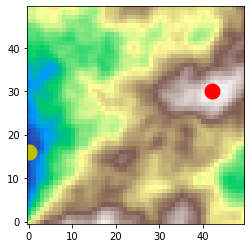

In [9]:
z = world
matplotlib.pyplot.imshow(z,origin='lower',cmap='terrain')

# Find maximum value index in numpy array
indices = np.where(z == z.max())
max_z_x_location, max_z_y_location = (indices[1][0],indices[0][0])
matplotlib.pyplot.plot(max_z_x_location,max_z_y_location,'ro',markersize=15)

# Find minimum value index in numpy array
indices = np.where(z == z.min())
min_z_x_location, min_z_y_location = (indices[1][0],indices[0][0])
matplotlib.pyplot.plot(min_z_x_location,min_z_y_location,'yo',markersize=15)

In [10]:
# Source: https://stackoverflow.com/questions/10996769/pixel-neighbors-in-2d-array-image-using-python
# This code by pv (https://stackoverflow.com/users/108184/pv), is to find all the adjacent values around a specific index
import numpy as np
from numpy.lib.stride_tricks import as_strided

def sliding_window(arr, window_size):
    """ Construct a sliding window view of the array"""
    arr = np.asarray(arr)
    window_size = int(window_size)
    if arr.ndim != 2:
        raise ValueError("need 2-D input")
    if not (window_size > 0):
        raise ValueError("need a positive window size")
    shape = (arr.shape[0] - window_size + 1,
             arr.shape[1] - window_size + 1,
             window_size, window_size)
    if shape[0] <= 0:
        shape = (1, shape[1], arr.shape[0], shape[3])
    if shape[1] <= 0:
        shape = (shape[0], 1, shape[2], arr.shape[1])
    strides = (arr.shape[1]*arr.itemsize, arr.itemsize,
               arr.shape[1]*arr.itemsize, arr.itemsize)
    return as_strided(arr, shape=shape, strides=strides)

def cell_neighbours(arr, i, j, d):
    """Return d-th neighbors of cell (i, j)"""
    w = sliding_window(arr, 2*d+1)

    ix = np.clip(i - d, 0, w.shape[0]-1)
    jx = np.clip(j - d, 0, w.shape[1]-1)

    i0 = max(0, i - d - ix)
    j0 = max(0, j - d - jx)
    i1 = w.shape[2] - max(0, d - i + ix)
    j1 = w.shape[3] - max(0, d - j + jx)

    return w[ix, jx][i0:i1,j0:j1].ravel()

In [11]:
from dataclasses import dataclass

@dataclass
class descent_step:
    """Class for storing each step taken in gradient descent"""
    value: float
    x_index: float
    y_index: float

def gradient_descent_3d(array,x_start,y_start,steps=50,step_size=1,plot=False):
    # Initial point to start gradient descent at
    step = descent_step(array[y_start][x_start],x_start,y_start)
    
    # Store each step taken in gradient descent in a list
    step_history = []
    step_history.append(step)
    
    # Plot 2D representation of array with startng point as a red marker
    if plot:
        matplotlib.pyplot.imshow(array,origin='lower',cmap='terrain')
        matplotlib.pyplot.plot(x_start,y_start,'ro')
    current_x = x_start
    current_y = y_start

    # Loop through specified number of steps of gradient descent to take
    for i in range(steps):
        prev_x = current_x
        prev_y = current_y
        
        # Extract array of neighbouring cells around current step location with size nominated
        neighbours=cell_neighbours(array,current_y,current_x,step_size)
        
        # Locate minimum in array (steepest slope from current point)
        next_step = neighbours.min()
        indices = np.where(array == next_step)
        
        # Update current point to now be the next point after stepping
        current_x, current_y = (indices[1][0],indices[0][0])
        step = descent_step(array[current_y][current_x],current_x,current_y)
        
        step_history.append(step)
        
        # Plot each step taken as a black line to the current point nominated by a red marker
        if plot:
            matplotlib.pyplot.plot([prev_x,current_x],[prev_y,current_y],'k-')
            matplotlib.pyplot.plot(current_x,current_y,'ro')
            
        # If step is to the same location as previously, this infers convergence and end loop
        if prev_y == current_y and prev_x == current_x:
            print(f"Converged in {i} steps")
            break
    return next_step,step_history

Target: -0.0994970053434372 @ (array([16]), array([0]))
Converged in 9 steps
Converged in 5 steps
Converged in 7 steps
Converged in 6 steps
Converged in 4 steps
Converged in 4 steps
Converged in 3 steps
Converged in 3 steps
Converged in 3 steps
Converged in 5 steps
Optimal step size 10
Converged in 5 steps
Steps: [descent_step(value=0.10347005724906921, x_index=38, y_index=28), descent_step(value=0.007558110170066357, x_index=28, y_index=38), descent_step(value=-0.03461135923862457, x_index=18, y_index=39), descent_step(value=-0.03682023286819458, x_index=8, y_index=35), descent_step(value=-0.07587684690952301, x_index=0, y_index=26), descent_step(value=-0.0994970053434372, x_index=0, y_index=16), descent_step(value=-0.0994970053434372, x_index=0, y_index=16)]


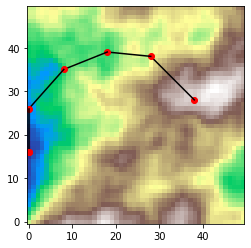

In [12]:
np.random.seed(42)
global_minimum = z.min()
indices = np.where(z == global_minimum)
print(f"Target: {global_minimum} @ {indices}")

step_size = 0
found_minimum = 99999

# Random starting point
start_x = np.random.randint(0,50)
start_y = np.random.randint(0,50)

# Increase step size until convergence on global minimum
while found_minimum != global_minimum:
    step_size += 1
    found_minimum,steps = gradient_descent_3d(z,start_x,start_y,step_size=step_size,plot=False)

print(f"Optimal step size {step_size}")
found_minimum,steps = gradient_descent_3d(z,start_x,start_y,step_size=step_size,plot=True)
print(f"Steps: {steps}")

In [13]:
# Source https://stackoverflow.com/questions/51272288/how-to-calculate-the-vector-from-two-points-in-3d-with-python

def multiDimenDist(point1,point2):
   #find the difference between the two points, its really the same as below
   deltaVals = [point2[dimension]-point1[dimension] for dimension in range(len(point1))]
   runningSquared = 0
   #because the pythagarom theorm works for any dimension we can just use that
   for coOrd in deltaVals:
       runningSquared += coOrd**2
   return runningSquared**(1/2)
def findVec(point1,point2,unitSphere = False):
  #setting unitSphere to True will make the vector scaled down to a sphere with a radius one, instead of it's orginal length
  finalVector = [0 for coOrd in point1]
  for dimension, coOrd in enumerate(point1):
      #finding total differnce for that co-ordinate(x,y,z...)
      deltaCoOrd = point2[dimension]-coOrd
      #adding total difference
      finalVector[dimension] = deltaCoOrd
  if unitSphere:
      totalDist = multiDimenDist(point1,point2)
      unitVector =[]
      for dimen in finalVector:
          unitVector.append( dimen/totalDist)
      return unitVector
  else:
      return finalVector

In [18]:
def generate_3d_plot(step_history):
    # Initialise empty lists for markers
    step_markers_x = []
    step_markers_y = []
    step_markers_z = []
    step_markers_u = []
    step_markers_v = []
    step_markers_w = []
    
    for index, step in enumerate(step_history):
        step_markers_x.append(step.x_index)
        step_markers_y.append(step.y_index)
        step_markers_z.append(step.value)
        
        # If we haven't reached the final step, calculate the vector between the current step and the next step
        if index < len(steps)-1:
            vec1 = [step.x_index,step.y_index,step.value]
            vec2 = [steps[index+1].x_index,steps[index+1].y_index,steps[index+1].value]

            result_vector = findVec(vec1,vec2)
            step_markers_u.append(result_vector[0])
            step_markers_v.append(result_vector[1])
            step_markers_w.append(result_vector[2])
        else:
            step_markers_u.append(0.1)
            step_markers_v.append(0.1)
            step_markers_w.append(0.1)
    
    # Include cones at each marker to show direction of step, scatter3d is to show the red line between points and surface for the terrain
    fig = go.Figure(data=[
        go.Cone(
        x=step_markers_x,
        y=step_markers_y,
        z=step_markers_z,
        u=step_markers_u,
        v=step_markers_v,
        w=step_markers_w,
        sizemode="absolute",
        sizeref=2,
        anchor='tail'),

        go.Scatter3d(
        x=step_markers_x,
        y=step_markers_y,
        z=step_markers_z,
        mode='lines',
        line=dict(
            color='red',
            width=4 # linewidth of gradient
        )),

        go.Surface(colorscale=terrain,z=world,opacity=0.7)])


    # Z axis is limited to the extent of the terrain array
    fig.update_layout(
        title='Gradient Descent Steps',
        scene = dict(zaxis = dict(range=[world.min(),world.max()],),),)
    return fig
    
# Generate 3D plot from previous random starting location
fig = generate_3d_plot(steps)
HTML(plotly.offline.plot(fig, filename='random_starting_point_3d_gradient_descent.html',include_plotlyjs='cdn'))

In [16]:
terrain

[[0.0, 'rgb(51, 51, 153)'],
 [0.003937007874015748, 'rgb(49, 53, 155)'],
 [0.007874015748031496, 'rgb(48, 56, 158)'],
 [0.011811023622047244, 'rgb(47, 59, 161)'],
 [0.015748031496062992, 'rgb(45, 61, 163)'],
 [0.01968503937007874, 'rgb(44, 64, 166)'],
 [0.023622047244094488, 'rgb(43, 67, 169)'],
 [0.027559055118110236, 'rgb(41, 69, 171)'],
 [0.031496062992125984, 'rgb(40, 72, 174)'],
 [0.03543307086614173, 'rgb(39, 75, 177)'],
 [0.03937007874015748, 'rgb(37, 77, 179)'],
 [0.04330708661417323, 'rgb(36, 80, 182)'],
 [0.047244094488188976, 'rgb(35, 83, 185)'],
 [0.051181102362204724, 'rgb(33, 85, 187)'],
 [0.05511811023622047, 'rgb(32, 88, 190)'],
 [0.05905511811023622, 'rgb(31, 91, 193)'],
 [0.06299212598425197, 'rgb(29, 93, 195)'],
 [0.06692913385826771, 'rgb(28, 96, 198)'],
 [0.07086614173228346, 'rgb(27, 98, 201)'],
 [0.07480314960629922, 'rgb(25, 101, 203)'],
 [0.07874015748031496, 'rgb(24, 104, 206)'],
 [0.0826771653543307, 'rgb(23, 107, 209)'],
 [0.08661417322834646, 'rgb(21, 109, 